In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import mode

from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder

import os
os.chdir("..")

import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, cohen_kappa_score
from multiprocessing.dummy import Pool
import pandas as pd


from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor, LBPDescriptor, DescriptorsTransformer
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesExtractor
from skin_lesion_cad.features.texture import glcm_features
from skin_lesion_cad.features.texture import get_glcm, lbph

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Counter
from sklearn.base import TransformerMixin, BaseEstimator

import scipy


from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import fbeta_score, make_scorer

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
classifiers = [(SVC(kernel='rbf', C=1, probability=True, class_weight='balanced'), 'full', 'svc_full'),
               (RandomForestClassifier(bootstrap=False, max_depth=10, class_weight='balanced'), 'smote', 'rf_smote'),
               (SVC(C=10, class_weight='balanced', gamma=0.1, probability=True), 'rf_fs', 'svc_rf_fs'),
               (RandomForestClassifier(bootstrap=False, max_depth=20, class_weight='balanced'), 'pca', 'rf_pca'),
               (SVC(kernel='rbf', C=1, probability=True, class_weight='balanced'), 'smote', 'svc_smote')]


TOP_FEATURES = ['bgr_b_mean', 'hsv_v_mean', 'bgr_r_entrp', 'hsv_v_entrp', 'bgr_r_mean',
                'bgr_b_entrp', 'hsv_s_std', 'bgr_b_std', 'hsv_v_std', 'YCrCb_Y_entrp',
                'bgr_r_skew', 'YCrCb_Y_mean', 'YCrCb_Y_skew', 'bgr_g_skew', 'bgr_r_std',
                'bgr_g_entrp', 'hsv_h_mean', 'bgr_b_kurt', 'YCrCb_C_std', 'bgr_b_min',
                'YCrCb_Y_std', 'bgr_b_skew', 'hsv_v_kurt', 'bgr_g_mean', 'hsv_v_skew',
                'YCrCb_C_mean', 'hsv_v_min', 'YCrCb_C_min', 'YCrCb_r_skew', 'bgr_g_std',
                'lbp_142', 'hsv_s_skew', 'bgr_r_min', 'bgr_b_unq', 'YCrCb_Y_min',
                'dissimilarity_2', 'bgr_g_min', 'hsv_v_unq', 'hsv_s_entrp',
                'hsv_h_entrp', 'dissimilarity_1', 'bow_22', 'hsv_v_max',
                'correlation_8', 'hsv_s_unq', 'lbp_147', 'bgr_g_max', 'bgr_r_kurt',
                'YCrCb_Y_max', 'lbp_148', 'correlation_16', 'YCrCb_r_max', 'bgr_r_max',
                'correlation_9', 'dissimilarity_3', 'hsv_s_kurt', 'correlation_5',
                'correlation_12', 'bgr_b_max', 'correlation_6', 'hsv_h_unq',
                'correlation_17', 'correlation_4', 'contrast_1', 'correlation_10',
                'correlation_15', 'correlation_13', 'YCrCb_C_max', 'YCrCb_r_unq',
                'correlation_11', 'YCrCb_C_skew', 'lbp_88', 'hsv_h_skew',
                'YCrCb_Y_kurt', 'YCrCb_r_min', 'YCrCb_C_unq', 'hsv_h_max',
                'correlation_7', 'YCrCb_Y_unq', 'bow_23', 'hsv_s_max', 'lbp_132',
                'correlation_0', 'bow_98', 'correlation_18', 'lbp_116',
                'correlation_19', 'correlation_2']

class EnsemblingClssfifier:
    def __init__(self, class_data:list, ensembling=None) -> None:
        self.class_data = class_data
        self.model_names = [x[2] for x in class_data]
        self.smote = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1, sampling_strategy='not majority')
        self.tf_fs_set = TOP_FEATURES
        self.transformer = DescriptorsTransformer(None)
        self.pca = PCA(n_components=0.95)
        self.ensembling = ensembling
        
    def fit(self, X, y, columns_X):
        """X - raw 442 shape array with features
        columngs_X - list of columns names used to make X
        only once pca per class  data"""
        # normalize data
        X = self.transformer.fit_transform(X)
        
        for model, dataset, name in self.class_data:
            if dataset == 'full':
                model.fit(X, y)
            elif dataset == 'smote':
                X_smote, y_smote = self.smote.fit_resample(X, y)
                model.fit(X_smote, y_smote)
            elif dataset == 'rf_fs':
                X_rf = X[:,np.isin(columns_X, self.tf_fs_set)]
                model.fit(X_rf, y)           
            elif dataset == 'pca':
                X_pca = self.pca.fit_transform(X)
                model.fit(X_pca, y)
            else:
                raise ValueError('Unknown dataset')
        
        if 'stacking' in self.ensembling:
            self.meta_model = LogisticRegression()
            predictions, predicitons_proba = self.predict(X, columns_X, False)
            predictions = {k:v for k,v in predictions.items() if k in self.model_names}
            predicitons_proba = {k:v for k,v in predicitons_proba.items() if k in self.model_names}
            self.meta_model.fit(np.hstack(predicitons_proba.values()), y)
        
    def predict(self, X, columns_X, with_meta=True):
        X = self.transformer.fit_transform(X)
        
        predictions = dict()
        predicitons_proba = dict()
        
        for model, dataset, name in self.class_data:
            if dataset == 'full':
                predictions[name] = model.predict(X)
                predicitons_proba[name] = model.predict_proba(X)

            elif dataset == 'smote':
                predictions[name] = model.predict(X)
                predicitons_proba[name] = model.predict_proba(X)
            
            elif dataset == 'rf_fs':
                X_rf = X[:,np.isin(columns_X, self.tf_fs_set)]
                predictions[name] = model.predict(X_rf)
                predicitons_proba[name] = model.predict_proba(X_rf)
            elif dataset == 'pca':
                X_pca = self.pca.transform(X)
                predictions[name] = model.predict(X_pca)
                predicitons_proba[name] = model.predict_proba(X_pca)
            else:
                raise ValueError('Unknown dataset')
        
        if 'stacking' in self.ensembling and with_meta:
            predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
            predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))
            
        if 'hard_voting' in self.ensembling:
            predictions['hard_voting'] = mode(np.stack([v for k,v in predictions.items() if k in self.model_names]), axis=0)[0][0]
            predicitons_proba['hard_voting'] = None
            
        if 'soft_voting' in self.ensembling:
            predicitons_proba['soft_voting'] = np.asarray([v for k, v in predicitons_proba.items() if k in self.model_names]).mean(axis=0)
            predictions['soft_voting'] = predicitons_proba['soft_voting'].argmax(axis=1)
            
        return predictions, predicitons_proba
    
    def evaluate(self, X, y, columns_X, plot=True):
        predictions, predicitons_proba = self.predict(X, columns_X)
        kappa_scores = {name: cohen_kappa_score(y, pred) for name, pred in predictions.items()}
        balacc_scores = {name: balanced_accuracy_score(y, pred) for name, pred in predictions.items()}
        
        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(18, 6))

            # plot bar plot of the dict
            sns.barplot(y=list(kappa_scores.values()), x=list(kappa_scores.keys()), ax=axs[0])
            axs[0].set_title('Kappa scores')
            axs[0].bar_label(axs[0].containers[0])

            sns.barplot(y=list(balacc_scores.values()), x=list(balacc_scores.keys()), ax=axs[1])
            axs[1].set_title('Balanced Accuracy scores')
            axs[1].bar_label(axs[1].containers[0])


            plt.show()
        return kappa_scores, balacc_scores

/tmp/ipykernel_15654/1732035255.py:66: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.meta_model.fit(np.hstack(predicitons_proba.values()), y)
/tmp/ipykernel_15654/1732035255.py:95: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/tmp/ipykernel_15654/1732035255.py:96: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_

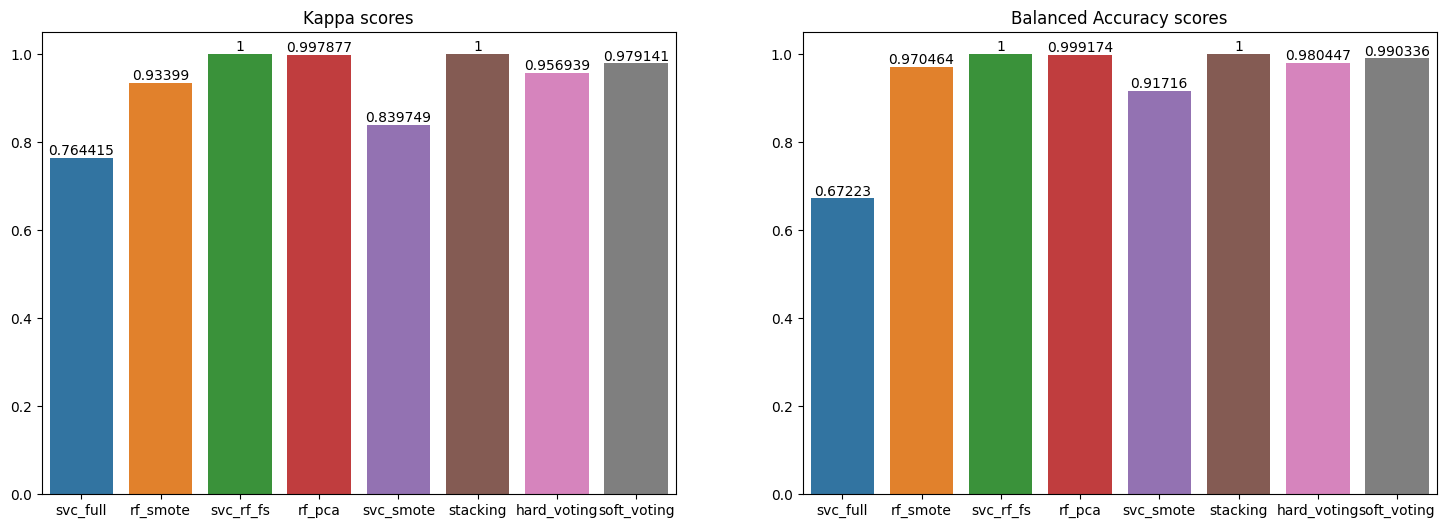

/tmp/ipykernel_15654/1732035255.py:95: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/tmp/ipykernel_15654/1732035255.py:96: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))


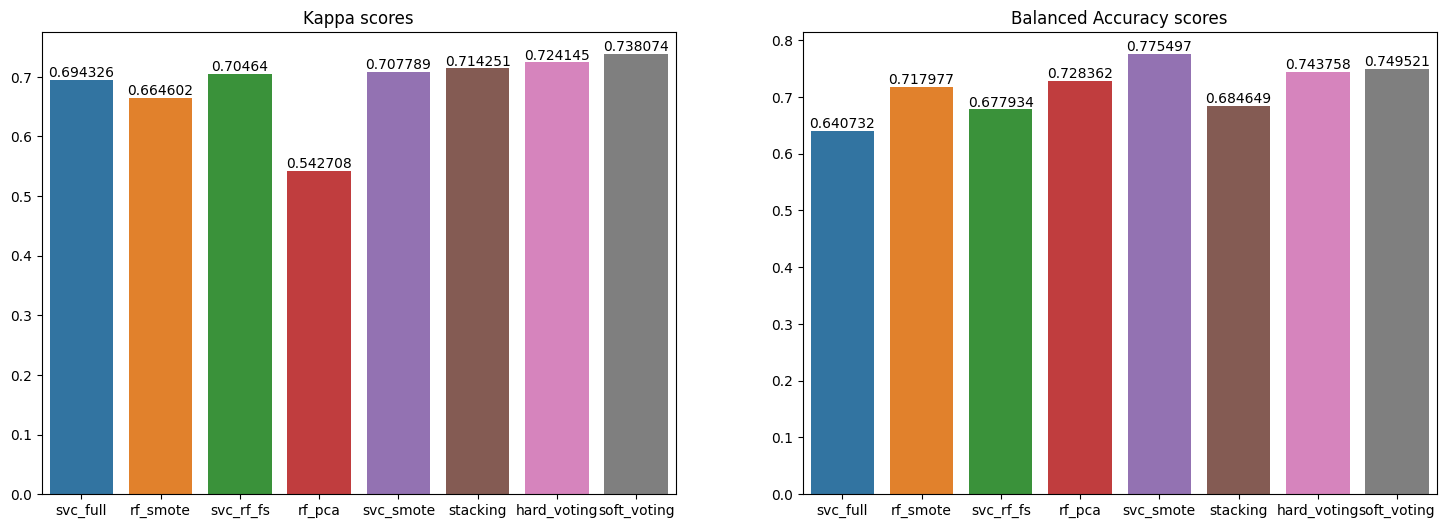

In [4]:
merged_df_val = pd.read_pickle('merged_df_val.pkl')
merged_df_train = pd.read_pickle('merged_df_train.pkl')
merged_df_TEST = pd.read_pickle('merged_df_TEST.pkl')

X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']


ens = EnsemblingClssfifier(classifiers, ['soft_voting', 'stacking', 'hard_voting'])

ens.fit(X_train.values, y_train.values, X_train.columns)
predictions, predicitons_proba = ens.predict(X_test.values, X_test.columns)
kappa_scores, balacc_scores = ens.evaluate(X_train.values, y_train.values, X_train.columns)
kappa_scores, balacc_scores = ens.evaluate(X_test.values, y_test.values, X_test.columns)

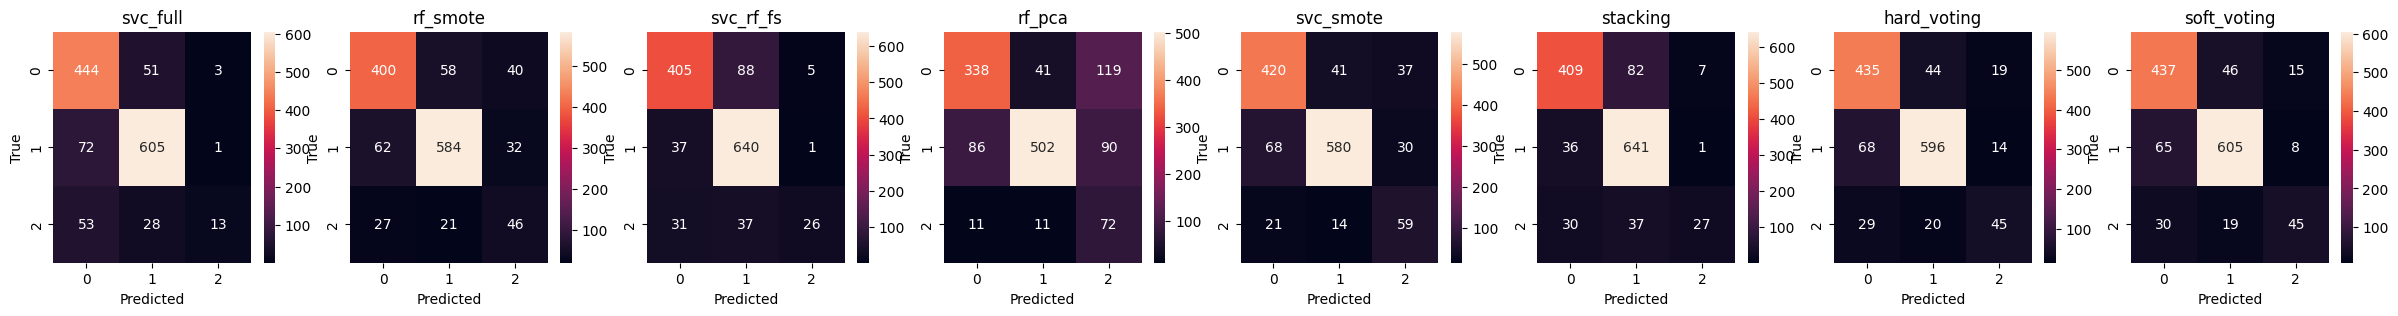

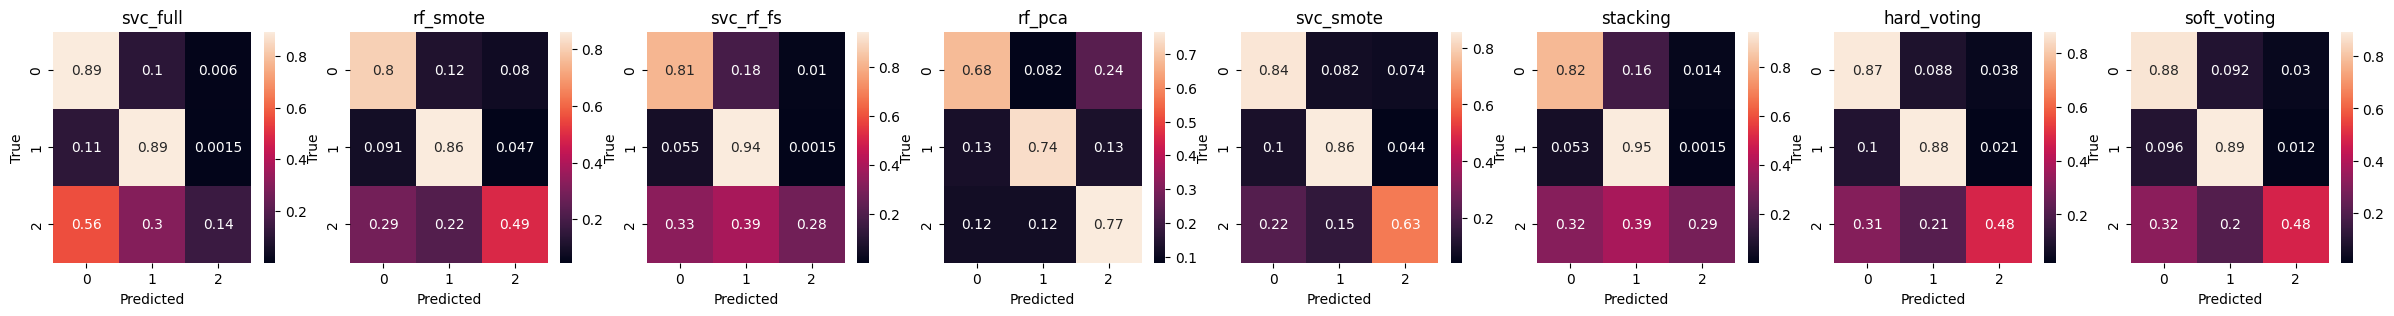

In [5]:
fig, axs = plt.subplots(1, len(predictions), figsize=(30, 3))

for i, (name, pred) in enumerate(predictions.items()):
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', ax=axs[i])
    axs[i].set_title(name)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
    
plt.show()

fig, axs = plt.subplots(1, len(predictions), figsize=(30, 3))

for i, (name, pred) in enumerate(predictions.items()):
    sns.heatmap(confusion_matrix(y_test, pred, normalize='true'), annot=True, ax=axs[i], )
    axs[i].set_title(name)
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('True')
    
plt.show()

# FIANL ETST

In [6]:
merged_df_val = pd.read_pickle('merged_df_val.pkl')
merged_df_train = pd.read_pickle('merged_df_train.pkl')
merged_df_TEST = pd.read_pickle('merged_df_TEST.pkl')

merged_ALL = pd.concat([merged_df_train, merged_df_val])

X_train = merged_ALL.drop(columns=['class'])
X_test = merged_df_TEST.drop(columns=['class'])
y_train = merged_ALL['class']
y_test = merged_df_TEST['class']


ens = EnsemblingClssfifier(classifiers, ['soft_voting', 'stacking', 'hard_voting'])

ens.fit(X_train.values, y_train.values, X_train.columns)
predictions, predicitons_proba = ens.predict(X_test.values, X_test.columns)

/tmp/ipykernel_15654/1732035255.py:66: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.meta_model.fit(np.hstack(predicitons_proba.values()), y)
/tmp/ipykernel_15654/1732035255.py:95: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/tmp/ipykernel_15654/1732035255.py:96: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_

/tmp/ipykernel_15654/1732035255.py:95: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predictions['stacking'] = self.meta_model.predict(np.hstack(predicitons_proba.values()))
/tmp/ipykernel_15654/1732035255.py:96: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  predicitons_proba['stacking'] = self.meta_model.predict_proba(np.hstack(predicitons_proba.values()))


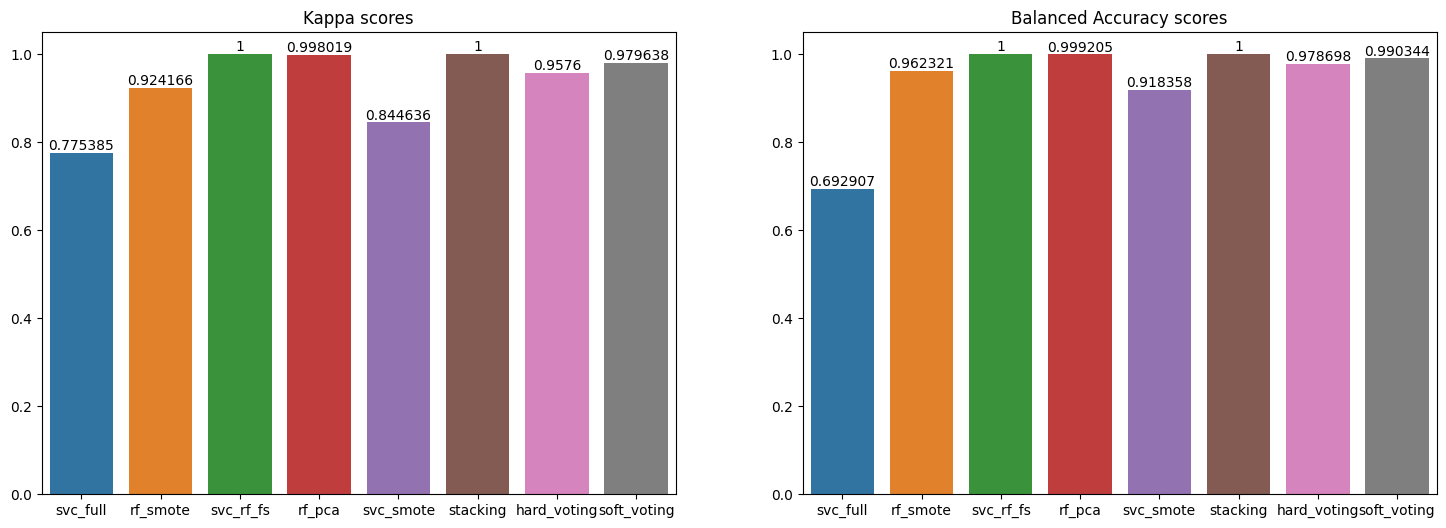

In [7]:
kappa_scores, balacc_scores = ens.evaluate(X_train.values, y_train.values, X_train.columns)

In [8]:
[(k, np.unique(predictions[k], return_counts=True)) for k in predictions.keys()]

[('svc_full', (array([0, 1]), array([ 75, 151]))),
 ('rf_smote', (array([0, 1, 2]), array([ 61, 146,  19]))),
 ('svc_rf_fs', (array([0, 1]), array([ 40, 186]))),
 ('rf_pca', (array([0, 1, 2]), array([ 54, 101,  71]))),
 ('svc_smote', (array([0, 1, 2]), array([ 64, 145,  17]))),
 ('stacking', (array([0, 1]), array([ 40, 186]))),
 ('hard_voting', (array([0, 1, 2]), array([ 68, 153,   5]))),
 ('soft_voting', (array([0, 1, 2]), array([ 66, 153,   7])))]

In [9]:
merged_df_TEST['predicted'] = predictions['svc_smote']

In [40]:
np.unique(predictions['svc_smote'], return_counts=True)

(array([0, 1, 2]), array([ 64, 145,  17]))

In [34]:
merged_df_TEST['predicted'] = predictions['svc_smote']
res = merged_df_TEST['predicted'].reset_index()
res['name'] = res.name.apply(lambda x: x.split('_')[0])
res = res.sort_values('name')

res.predicted = res.predicted.replace({1:0, 0:1})
res.to_csv('chall2_sumb.csv', index=False)
res

,name,predicted
147,xxx0001,0
87,xxx0002,1
59,xxx0003,0
213,xxx0004,1
83,xxx0005,0
...,...,...
90,xxx0222,0
162,xxx0223,1
174,xxx0224,1
89,xxx0225,0
